In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle

# Save Results

## Load mlflow runs

In [2]:
results_dir = Path.cwd().parent / "results" / "scale_features"
os.makedirs(results_dir, exist_ok=True)

In [3]:
db_port = 5001
db_name = 'cohirf'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()


In [4]:
experiment_names

['Default',
 'sfni-SpectralSubspaceRandomization',
 'sfni-KMeans',
 'sfni-BatchCoHiRF-SC-SRGF',
 'sfni-BatchCoHiRF-1iter',
 'sfni-CoHiRF',
 'sphere-BatchCoHiRF-DBSCAN-1iter',
 'sphere-DBSCAN',
 'sphere-CoHiRF-DBSCAN',
 'real-ari-BatchCoHiRF-1iter',
 'real-ari-AverageAgglomerativeClustering',
 'real-ari-BatchCoHiRF-DBSCAN-1iter',
 'real-ari-AffinityPropagation',
 'real-ari-BatchCoHiRF-SC-SRGF',
 'real-ari-CoHiRF-DBSCAN',
 'real-ari-CoHiRF-KernelRBF',
 'real-ari-CoHiRF',
 'real-ari-CompleteAgglomerativeClustering',
 'real-ari-DBSCAN',
 'real-ari-HDBSCAN',
 'real-ari-IRFLLRR',
 'real-ari-KMeans',
 'real-ari-MeanShift',
 'real-ari-OPTICS',
 'real-ari-Proclus',
 'real-ari-SingleAgglomerativeClustering',
 'real-ari-SpectralClustering',
 'real-ari-SpectralSubspaceRandomization',
 'real-ari-WardAgglomerativeClustering',
 'real-adjusted_mutual_info-BatchCoHiRF-DBSCAN-1iter',
 'real-adjusted_mutual_info-DBSCAN',
 'real-adjusted_mutual_info-BatchCoHiRF-SC-SRGF',
 'real-adjusted_mutual_info-Comple

In [5]:
experiments_names = [exp for exp in experiment_names if exp.startswith('sfni')]

In [6]:
experiments_names

['sfni-SpectralSubspaceRandomization',
 'sfni-KMeans',
 'sfni-BatchCoHiRF-SC-SRGF',
 'sfni-BatchCoHiRF-1iter',
 'sfni-CoHiRF',
 'sfni-CoHiRF-top-down-inv',
 'sfni-CoHiRF-1000',
 'sfni-CoHiRF-top-down']

In [7]:
params_columns = [
    # "model_nickname",
    "model",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_random",
    "n_informative",
    "n_features_dataset",
    "pct_random",
    "class_sep",
    # "seed_unified",
    "n_classes",
    "best/child_run_id",
]

In [8]:
latest_metrics_columns = [
    "fit_model_return_elapsed_time",
    # "best_n_clusters_",
    # "best_rand_score",
    # "best_adjusted_rand",
    # "best_mutual_info",
    # "best_adjusted_mutual_info",
    # "best_normalized_mutual_info",
    # "best_homogeneity_completeness_v_measure",
    # "best_silhouette",
    # "best_calinski_harabasz_score",
    # "best_davies_bouldin_score",
    # "best_inertia_score",
    # "best_homogeneity",
    # "best_completeness",
    # "best_v_measure",
    "best/n_clusters_",
    "best/rand_score",
    "best/adjusted_rand",
    "best/mutual_info",
    "best/adjusted_mutual_info",
    "best/normalized_mutual_info",
    "best/homogeneity_completeness_v_measure",
    "best/silhouette",
    "best/calinski_harabasz_score",
    # "best/davies_bouldin_score",
    # "best/inertia_score",
    "best/homogeneity",
    "best/completeness",
    "best/v_measure",
	"best/elapsed_time",
]

In [9]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'mlflow.parentRunId',
    # 'best_child_run_id',
]

In [10]:
# # parameters of each model, they are saved as tags for the parent run
# parameters = {
#     'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
#     'KMeans': ['n_clusters'],
#     'HDBSCAN': ['min_cluster_size'],
#     'DBSCAN': ['eps', 'min_samples'],
#     'AffinityPropagation': ['damping'],
#     'OPTICS': ['min_samples'],
#     'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
#     'WardAgglomerativeClustering': ['n_clusters'],
# }
# all_model_parameters = [p for model, params in parameters.items() for p in params]
# all_model_parameters = list(set(all_model_parameters))
# for param in all_model_parameters:
#     tags_columns.append(param)

In [11]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [12]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)


In [13]:
# df_runs_raw.loc[df_runs_raw.model_nickname.isna(), 'model_nickname'] = df_runs_raw.loc[df_runs_raw.model_nickname.isna(), 'model']
# df_runs_raw.loc[df_runs_raw.seed_unified.isna(), 'seed_unified'] = df_runs_raw.loc[df_runs_raw.seed_unified.isna(), 'seed_dataset']
# columns_best_ = [col for col in df_runs_raw.columns if col.startswith('best_')]
# for col in columns_best_:
# 	col_slash = col.replace('best_', 'best/')
# 	df_runs_raw.loc[df_runs_raw[col].isna(), col] = df_runs_raw.loc[df_runs_raw[col].isna(), col_slash]

In [14]:
df_runs_raw.to_csv(results_dir / 'df_runs_raw.csv', index=True)

In [15]:
df_runs_raw = pd.read_csv(results_dir / "df_runs_raw.csv", index_col=0)
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['mlflow.parentRunId'].isna()]

In [16]:
df_runs_raw_parents

,status,start_time,end_time,best/child_run_id,class_sep,model,n_classes,n_features_dataset,n_informative,n_random,...,best/homogeneity,best/mutual_info,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,mlflow.parentRunId,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
007fee15b8084c76bd9a1adece08e221,FINISHED,1761235641082,1761235809485,1c461aed6c1245f88732959bc6a846b2,5.196152,CoHiRF,5,NaN,3,10000,...,0.818262,1.316942,7.0,0.883939,0.916751,-0.001838,0.883939,158.163398,NaN,False
0124c7658514474cb20555c6e64fb78a,FINISHED,1751650382613,1751650452465,860b255ec305490eb4d7b7c43295e11b,5.196152,BatchCoHiRF-1iter,5,NaN,3,100,...,0.948261,1.526167,122.0,0.571078,0.850438,-0.089212,0.571078,67.864262,NaN,False
01eca8c3d6e841a59a6a18914789b2bd,FINISHED,1751647665011,1751647717843,4a23f00309ca4b8d8526612bdf2ada64,5.196152,CoHiRF,5,NaN,3,100,...,1.000000,1.609438,5.0,1.000000,1.000000,0.184877,1.000000,49.950107,NaN,False
0224d45541f84454a5209c9b55a12b25,FINISHED,1761236542420,1761236648960,1343bd0a76974a78b47729d3e29d5069,5.196152,CoHiRF-top-down-inv,5,NaN,3,10,...,1.000000,1.609438,5.0,1.000000,1.000000,0.551172,1.000000,95.817897,NaN,False
02342935ef274d998e1a1591b11313ec,FINISHED,1751909827280,1751909851989,b097d56595154fe388815e483556c4d1,5.196152,KMeans,5,NaN,3,10,...,1.000000,1.609438,7.0,0.936139,0.973325,0.455714,0.936139,17.669570,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f5cf230c017043ccaa8d7b69a148d512,FINISHED,1761235357918,1761235503561,0e710df7fa0f4f1599a5633f9fafe962,5.196152,CoHiRF-1000,5,NaN,3,10,...,1.000000,1.609438,5.0,1.000000,1.000000,0.560879,1.000000,135.571672,NaN,False
f6faa1c7ea3b4f62997e8020c7f752c7,FINISHED,1761235356216,1761235487622,df1cff92327c473ea0eb3286c9b6ce21,5.196152,CoHiRF-1000,5,NaN,3,10,...,1.000000,1.609438,5.0,1.000000,1.000000,0.566909,1.000000,120.389055,NaN,False
fa1acc56990342518bbe494c44f865ad,FINISHED,1761235662370,1761235763332,3841afefd80d437e8e7938be0279d802,5.196152,KMeans,5,NaN,3,10,...,1.000000,1.609438,5.0,1.000000,1.000000,0.554103,1.000000,91.092835,NaN,False


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [17]:
non_duplicate_columns = [
    # "model_nickname",
	"model",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_random",
    "n_informative",
    "n_features_dataset",
    "pct_random",
    "class_sep",
    # "seed_unified",
    "n_classes",
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how="all", subset=["best/adjusted_rand"]).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]
# fill missing values with "None"
df_runs_parents = df_runs_parents.fillna("None")

# Missing

In [18]:
model_nickname = df_runs_parents['model'].unique().tolist()
model_nickname.sort()
model_nickname

['BatchCoHiRF-1iter',
 'BatchCoHiRF-SC-SRGF',
 'CoHiRF',
 'CoHiRF-1000',
 'CoHiRF-top-down',
 'CoHiRF-top-down-inv',
 'KMeans',
 'SpectralSubspaceRandomization']

In [19]:
model_nickname = [
    "CoHiRF",
    "KMeans",
    "CoHiRF-1000",
    "CoHiRF-top-down",
    "CoHiRF-top-down-inv",
]

In [20]:
non_duplicate_columns = [
    "model",
    "n_random",
    "seed_dataset",
	"n_informative",
	"n_samples",
    "n_classes",
]

In [21]:
n_informative = [3]
n_samples = [1000]
n_classes = [5]
n_random = [10, 100, 1000, 10000]
seed_dataset = [i for i in range(5)]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_random, seed_dataset, n_informative, n_samples, n_classes]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)
# df_missing = df_missing.rename(columns={"seed_unified": "seeds_unified"})

In [22]:
df_missing

,model,n_random,seed_dataset,n_informative,n_samples,n_classes


In [23]:
# Join df_runs_raw_parents into df_missing using non_duplicate_columns to get the EXCEPTION column
df_missing_with_exception = df_missing.merge(
    df_runs_raw_parents[non_duplicate_columns + ["raised_exception"]],
    how="left",
    left_on=["model", "n_random", "seed_dataset", "n_informative"],
    right_on=["model", "n_random", "seed_dataset", "n_informative"],
)
df_missing_with_exception[["model", "n_random", "seed_dataset", "n_informative", "raised_exception"]]

,model,n_random,seed_dataset,n_informative,raised_exception


In [33]:
df_missing["hpo_seed"] = df_missing["seed_dataset"]
df_missing["class_sep"] = 3*(df_missing["n_informative"]**0.5)
df_missing.to_csv(results_dir / "df_missing.csv")

# Plots

In [24]:
def plot_results(df):
    plt.style.use("seaborn-v0_8-whitegrid")
    with mpl.rc_context(
        rc={
            "figure.constrained_layout.use": True,
            "savefig.bbox": "tight",
            "figure.figsize": (12, 7),
            "legend.loc": "upper left",
            "legend.frameon": True,
            "font.size": 14,
            "axes.titlesize": 16,
            "axes.labelsize": 15,
            "xtick.labelsize": 13,
            "ytick.labelsize": 13,
            "axes.grid": True,
            "grid.color": "grey",
            "grid.alpha": 0.3,
        }
    ):
        fig, axs = plt.subplots(2, 1, sharex=True)
        axs = axs.flatten()
        palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
        # Time plot
        ax = sns.lineplot(
            data=df,
            x="Number of Non Informative Features",
            y="Time (s)",
            hue="Model",
            style="Model",
            markers=True,
            dashes=False,
            errorbar="ci",
            ax=axs[0],
            palette=palette,
        )
        ax.set_yscale("log")
        ax.set_ylabel("Time (s)")
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        # ARI plot
        ax2 = sns.lineplot(
            data=df,
            x="Number of Non Informative Features",
            y="ARI",
            hue="Model",
            style="Model",
            markers=True,
            dashes=False,
            errorbar="ci",
            ax=axs[1],
            palette=palette,
        )
        ax2.set_ylabel("Adjusted Rand Index (ARI)")
        ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax2.set_xscale("log")
        # Remove duplicate legends
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
        ax.get_legend().remove()
        ax2.get_legend().remove()
        plt.xlabel("Number of Non Informative Features")
        plt.tight_layout()
        return fig, axs

## HPO Time

/tmp/ipykernel_7118/1432943101.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


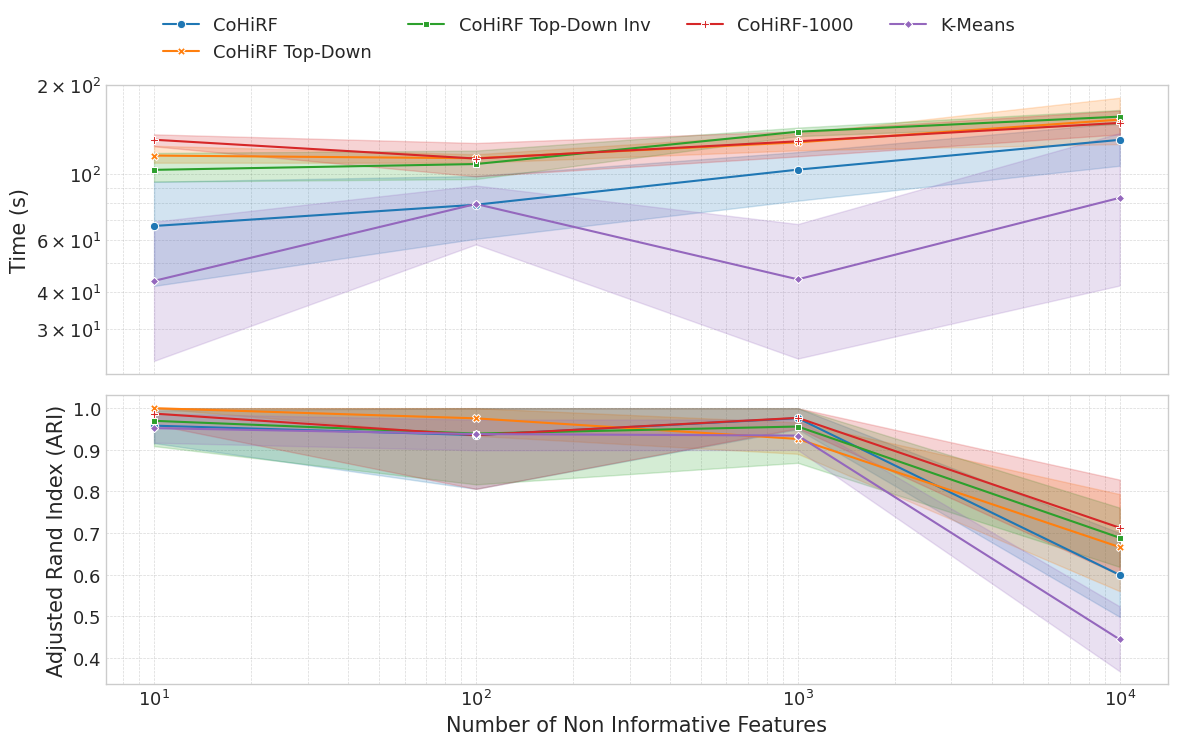

In [26]:
df = df_runs_parents.copy()
n_informative = 3
n_samples = 1000
n_classes = 5
class_sep = 3*(n_informative**0.5)
models_names = {
    "CoHiRF": "CoHiRF",
    "CoHiRF-1000": "CoHiRF-1000",
    "CoHiRF-top-down": "CoHiRF Top-Down",
    "CoHiRF-top-down-inv": "CoHiRF Top-Down Inv",
    "KMeans": "K-Means",
}
df = df.loc[
    (df["n_informative"] == n_informative)
    & (df["n_samples"] == n_samples)
    & (df["n_classes"] == n_classes)
    & (df["class_sep"] == class_sep)
    & (df["model"].isin(models_names.keys()))
]
df = df.replace({"model": models_names})
df = df.sort_values(by="model")
df = df.rename(
    columns={
        "fit_model_return_elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "n_random": "Number of Non Informative Features",
        "model": "Model",
        "best/adjusted_rand": "ARI",
    }
)

fig, axs = plot_results(df)
fig.savefig(results_dir / f"scale_features_non_informatives_results_n_samples_{n_samples}_n_classes_{n_classes}.pdf", dpi=300)
plt.show()


## Best Time

/tmp/ipykernel_50386/1432943101.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


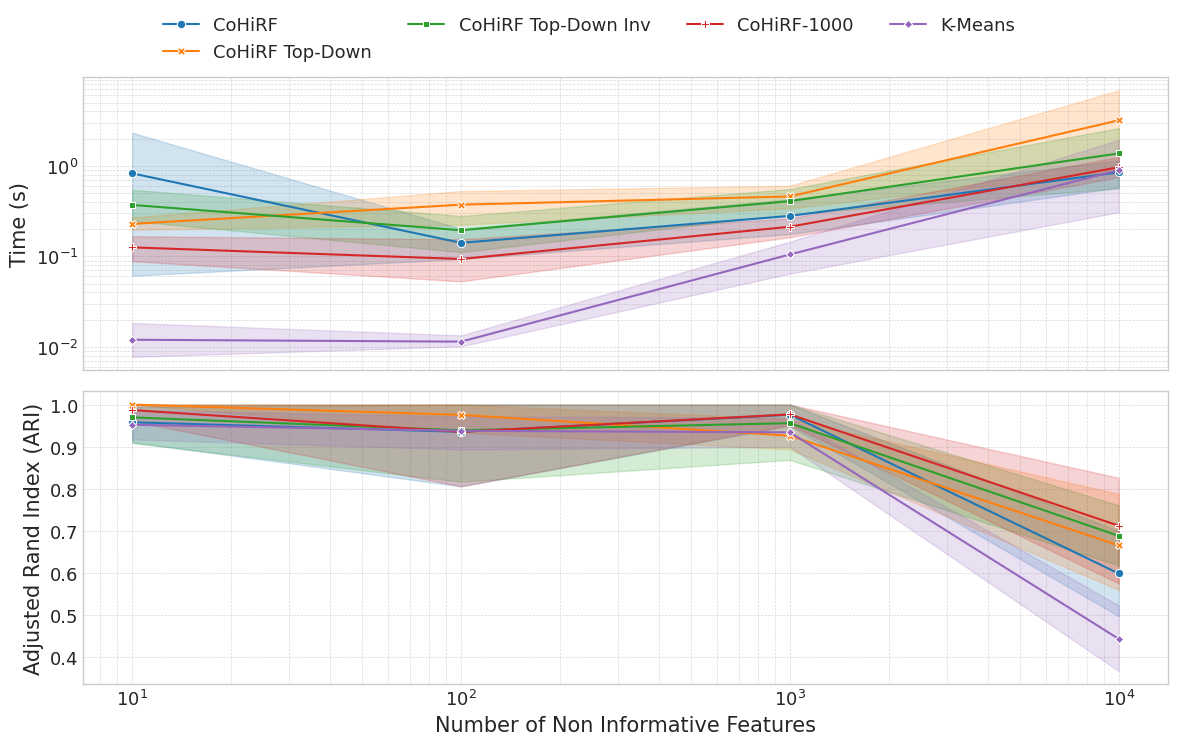

In [63]:
df = df_runs_parents.copy()
n_informative = 3
n_samples = 1000
n_classes = 5
class_sep = 3 * (n_informative**0.5)
models_names = {
    "CoHiRF": "CoHiRF",
    "CoHiRF-1000": "CoHiRF-1000",
    "CoHiRF-top-down": "CoHiRF Top-Down",
    "CoHiRF-top-down-inv": "CoHiRF Top-Down Inv",
    "KMeans": "K-Means",
}
df = df.loc[
    (df["n_informative"] == n_informative)
    & (df["n_samples"] == n_samples)
    & (df["n_classes"] == n_classes)
    & (df["class_sep"] == class_sep)
    & (df["model"].isin(models_names.keys()))
]
df = df.replace({"model": models_names})
df = df.sort_values(by="model")
df = df.rename(
    columns={
        "best/elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "n_random": "Number of Non Informative Features",
        "model": "Model",
        "best/adjusted_rand": "ARI",
    }
)

fig, axs = plot_results(df)
plt.show()

/tmp/ipykernel_180745/3722283627.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


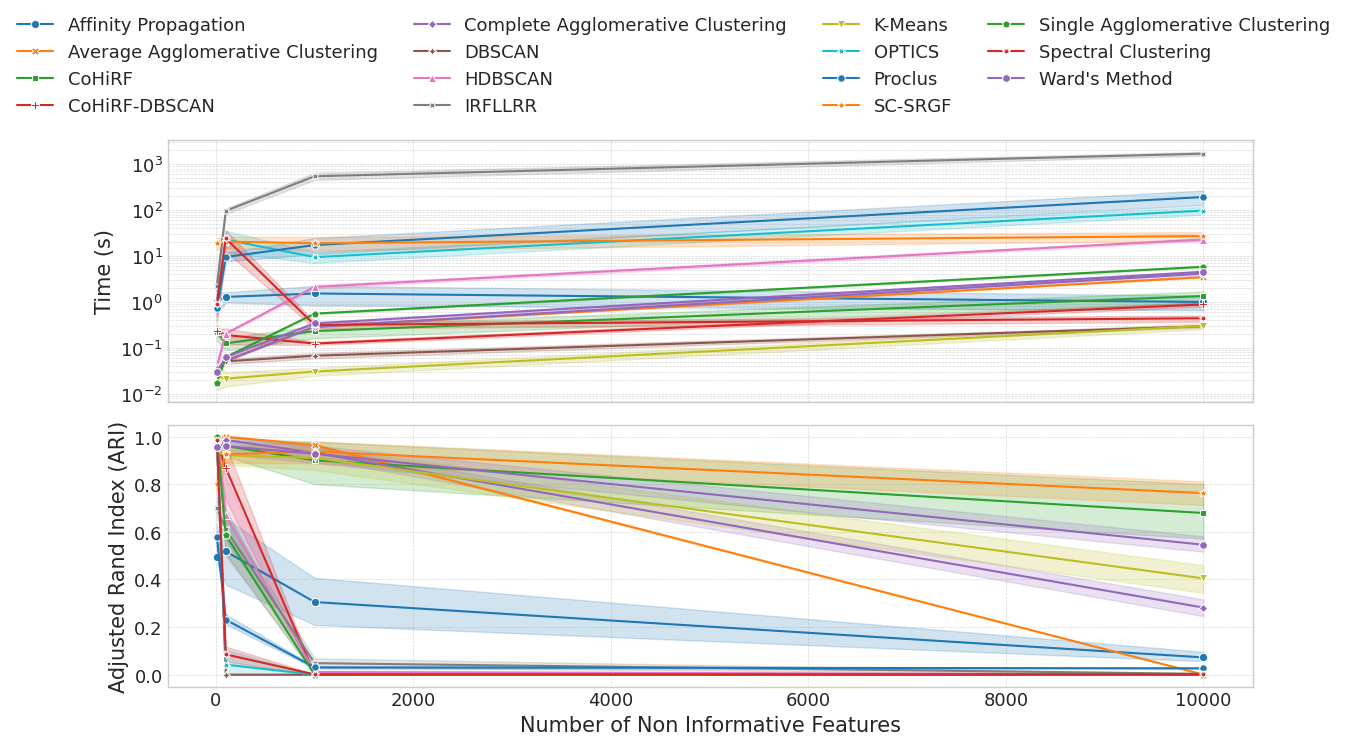

In [41]:
import matplotlib.ticker as mticker

df = df_common.copy()
n_informative = 3
n_samples = 1000
models_names = {
    "AffinityPropagation": "Affinity Propagation",
    "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    "DBSCAN": "DBSCAN",
    "HDBSCAN": "HDBSCAN",
    "IRFLLRR": "IRFLLRR",
    "KMeans": "K-Means",
    "OPTICS": "OPTICS",
    "Proclus": "Proclus",
    "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    "SpectralClustering": "Spectral Clustering",
    "SpectralSubspaceRandomization": "SC-SRGF",
    "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["n_informative"] == n_informative]
df = df.loc[df["n_samples"] == n_samples]
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
df = df.rename(
    columns={
        "best_child_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "n_random": "Number of Non Informative Features",
        "model_nickname": "Model",
        "best_adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of Non Informative Features")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.savefig(
        results_dir / f"best_non_informative_features_n-informative_{n_informative}_n-samples_{n_samples}_all.pdf",
        dpi=300,
    )
    plt.show()

# Debug and explore

In [61]:
df_runs_raw.model_nickname.unique()

array(['IRFLLRR', 'Clique', 'KMeans', 'HDBSCAN',
       'CompleteAgglomerativeClustering', 'SpectralClustering',
       'AffinityPropagation', 'MeanShift', 'Proclus', 'CoHiRF-DBSCAN',
       'WardAgglomerativeClustering', 'BatchCoHiRF', 'OPTICS',
       'AverageAgglomerativeClustering', 'CoHiRF',
       'SpectralSubspaceRandomization', 'SingleAgglomerativeClustering',
       'DBSCAN', 'KMeansProj', 'BatchCoHiRF-1iter', 'BatchCoHiRF-SC-SRGF'],
      dtype=object)

In [62]:
df = df_runs_raw.copy()
df = df.loc[df["model_nickname"].isin(["BatchCoHiRF", "BatchCoHiRF-1iter", "BatchCoHiRF-SC-SRGF"])]

In [63]:
runs_to_delete = list(df.index)
runs_to_delete

['0054024430624df788218bf1144bccfa',
 '009de77bd21c4a73b29570ddd38e3ebc',
 '01b20bfddc71497992030240859e1990',
 '01db37fec1e9472999c14d6e1bb9356a',
 '01ff92eeea644cfc8b7913a95d51c283',
 '034b82d86a0847d592db1df960b7508a',
 '044722147de84e69990237d75b6ccc5f',
 '054037a35e014d69be34d750172e878c',
 '069a4c5f03f940c98f24cda0912bff07',
 '069fb75625ef42ed8e264802b416c45e',
 '083351ee3a5e42988189526d61e5ef69',
 '08e82bc8f18f458aa67ec90aec842a30',
 '0947a4b7bdd04a429977693106b6318e',
 '0a50c6b346db4412b666089f5a6942b3',
 '0a68c69500c249eb899d908ef43e6ad1',
 '0acc99a51ccb4dd1a2b256e59b4fb0f3',
 '0adeed5ea4df433e90281491d2aa75b9',
 '0ae5807e11624cc188abe8a1c09458b2',
 '0b0d8d690bef4963bf4a82866b02a762',
 '0b1798410c5a4b9fb64209dc7bf9ebf3',
 '0b8028f827ae4933afe6ab2eed290f09',
 '0c901a07f420407b84a2d5717088e5da',
 '0cb090b3aec6429c8503ac0fa3e90432',
 '0cfd76c2ac7c4634bda88ef8962695ec',
 '0e267bd74ba94919af9eabd2838d03a9',
 '0e6e992ce40941d1ae31de0c9adaae89',
 '0ee1aea380ee4b8990e2358ab799a48d',
 

In [64]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [65]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

In [66]:
query = f"""
DELETE
FROM
	experiment_tags
WHERE
	experiment_id = ANY(
	SELECT
		experiment_id
	FROM
		experiments
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	latest_metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	params
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	tags
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE 
FROM 
	runs
WHERE 
	lifecycle_stage = 'deleted';

DELETE 
FROM 
	experiments
WHERE 
	lifecycle_stage = 'deleted';
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    